In [44]:
# ✅
import torch
print(torch.__version__)
print(torch.cuda.is_available())   # False (expected)


2.9.1
False


In [45]:
# ✅
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim

In [ ]:
# !pip install torch torchvision torchaudio --upgrade

In [46]:
# ✅
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

Device: cpu


In [47]:
# ✅
import torch

print("CUDA available:", torch.cuda.is_available())   # True = NVIDIA GPU usable
print("MPS available:", torch.backends.mps.is_available())  # True = Apple GPU usable (M1/M2/M3)

device = (
    "cuda" if torch.cuda.is_available() else      # NVIDIA GPU
    "mps" if torch.backends.mps.is_available() else  # Apple M1/M2/M3 GPU
    "cpu"  # fallback to CPU
)

print("Using device:", device)

CUDA available: False
MPS available: True
Using device: mps


In [ ]:
# have pip install kagglehub done 
# import kagglehub

# path = kagglehub.dataset_download(
#     "mahmoudreda55/satellite-image-classification"
#) 
#print(path)
# done once 

In [48]:
# ✅
import os

data_dir = "data"           # folder containing class subfolders
class_names = os.listdir(data_dir)  # automatically gets ["clouds","desert","green","water"]
print("Classes:", class_names)


Classes: ['cloudy', 'water', 'green_area', 'desert']


In [50]:
# ✅
def path_data(root_dir):
    # class_names is already defined globally from data_subdir, so we can reuse it.
    class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}

    img_paths = []
    labels = []

    for cls_name in class_names:
        cls_dir = os.path.join(root_dir, cls_name)
        for fname in os.listdir(cls_dir):
            img_paths.append(os.path.join(cls_dir, fname))
            labels.append(class_to_idx[cls_name])

    return img_paths, labels, class_names, class_to_idx

# Pass data_subdir instead of path to path_data
img_paths, labels, class_names, class_to_idx = path_data(data_dir)

print("Classes:", class_names)
print("Image count:", len(img_paths))

Classes: ['cloudy', 'water', 'green_area', 'desert']
Image count: 5631


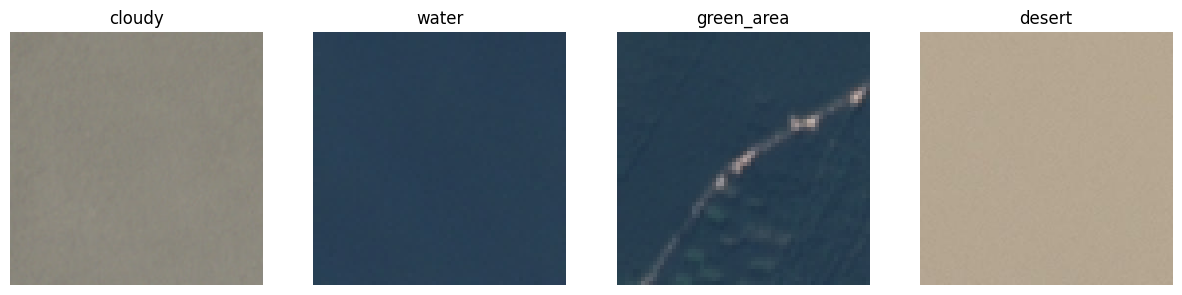

In [51]:
# ✅
def show_one_image_per_class(data_dir, class_names):
    plt.figure(figsize=(15, 5))
    shown_classes = set()

    for i, cls in enumerate(class_names):
        cls_folder = os.path.join(data_dir, cls)
        # Only include real image files
        images = [f for f in os.listdir(cls_folder) if f.lower().endswith(('.png','.jpg','.jpeg'))]
        if not images:
            print(f"No images found for class: {cls}")
            continue
        # Pick one random image
        img_path = os.path.join(cls_folder, random.choice(images))
        img = Image.open(img_path).convert("RGB")

        plt.subplot(1, len(class_names), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
        shown_classes.add(cls)

    plt.show()



show_one_image_per_class(data_dir, class_names)






In [52]:
# ✅
TrainVal_paths, Test_paths, TrainVal_labels, Test_labels = train_test_split(
    img_paths, labels, test_size=0.1, random_state=42, stratify=labels
)

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(
    TrainVal_paths, TrainVal_labels, test_size=0.2, random_state=42, stratify=TrainVal_labels
)

print("Train images count:", len(Train_paths))
print("Validation images count:", len(Val_paths))
print("Test images count:", len(Test_paths))

Train images count: 4053
Validation images count: 1014
Test images count: 564


In [53]:
# ✅
class Satellite_dataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx]).convert("RGB")
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label

In [54]:
# ✅
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# Lite Train Transform  data augmentation 
# with BatchNorm and  AdamW  and schejuler   Best Validation Accuracy: 0.9379  Test Accuracy: 0.9078
train_transform_lite = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.9, 1.0)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225])
])


In [55]:
# ✅
import torchvision.transforms as transforms

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
Train_D = Satellite_dataset(Train_paths, Train_labels, transform=test_transform)
Val_D = Satellite_dataset(Val_paths, Val_labels, transform=test_transform)
Test_D = Satellite_dataset(Test_paths, Test_labels, transform=test_transform)

In [ ]:
# with BatchNorm and  AdamW  and schejuler   Best Validation Accuracy: 0.9379  Test Accuracy: 0.9078 worse than lite   
train_transform_aggressive = transforms.Compose([
    transforms.Resize((224, 224)),              # final size divisible by 7
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=90),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])


In [56]:
# ✅
from torch.utils.data import DataLoader

Train_B = DataLoader(
    Train_D,
    batch_size=32,
    shuffle=True,
    num_workers=0,   # MPS is safer with 0
    pin_memory=False
)
Val_B = DataLoader(Val_D, batch_size=32, shuffle=False)
Test_B = DataLoader(Test_D, batch_size=32, shuffle=False)


In [ ]:
# too heavy one epoch takes 1 hrs overkill
# standard vgg model convolution -> maxpool
# 10 conv layers
# 3–4 pooling layers
# Channels go: 3 → 64 → 128 → 256 → 512
# Output feature maps very wide → huge classifier
# BatchNorm optional 
'''
[Conv 64]
[Conv 64]
[MaxPool]

[Conv 128]
[Conv 128]
[MaxPool]

[Conv 256]
[Conv 256]
[Conv 256]
[MaxPool]

[Conv 512]
[Conv 512]
[Conv 512]
[MaxPool]

[Conv 512]
[Conv 512]
[Conv 512]
[MaxPool]

[FC 4096]
[FC 4096]
[FC 1000]
'''
class VGG(nn.Module):
    def __init__(self, num_classes=4, cfg=None, batch_norm=True, dropout_rate=0.5):

        super().__init__()

        # Default VGG16-like config
        if cfg is None:
            cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M']

        self.features = self._make_layers(cfg, batch_norm)

        self.features = nn.Sequential(
    self._make_layers(cfg, batch_norm),
    nn.AdaptiveAvgPool2d((7,7))  # now output will always be [batch, 512, 7,7]
)

        # Fully connected classifier
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512*7*7, 4096),  # assume input images 224x224
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(4096, num_classes)
        )

    def _make_layers(self, cfg, batch_norm):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                conv2d = nn.Conv2d(in_channels, x, kernel_size=3, padding=1)
                if batch_norm:
                    layers += [conv2d, nn.BatchNorm2d(x), nn.ReLU(inplace=True)]
                else:
                    layers += [conv2d, nn.ReLU(inplace=True)]
                in_channels = x
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [ ]:
# faster but still overkill small dataset overfits easily no space for custumization
from torchvision import models

class FastVGG(nn.Module):
    def __init__(self, num_classes=4, dropout_rate=0.5):
        super().__init__()
        # Load VGG16 pretrained on ImageNet
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.features = vgg16.features  # keep conv layers

        # Freeze feature layers to avoid training them (optional)
        for param in self.features.parameters():
            param.requires_grad = False

        # New classifier for your 4 classes
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),  # global pooling -> [batch, 512, 1,1]
            nn.Flatten(),
            nn.Linear(512, 256),
            nn.ReLU(True),
            nn.Dropout(dropout_rate),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
import torch
import torch.nn as nn
# first try noot bad  Best Validation Accuracy: 0.9152 epochs 10 with 6 min each 
# Only 4 conv layers
# Only 2 pooling layers
# Channels: 3 → 32 → 64

class MiniVGG(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /2

            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)      
        x = self.classifier(x)
        return x


In [ ]:
# gradient clipped  5 to 6 min not much of a difference 0.9152 epochs 10 with 6 min each 
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=5):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    best_model_state = None
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader, 1):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            #  Clip gradients  aint that deep 
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)

            optimizer.step()
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.max(outputs, 1)[1]
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
        history["val_accuracy"].append(val_acc)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return history, model


In [ ]:

# try later

# make batch bigger 

# nn.Dropout(0.6),  # Add second: nn.Dropout(0.3) before final Linear

# later on already changes of parameters 
# optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.05)  # Lower LR + higher WD

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# with BatchNorm and  AdamW Best Validation Accuracy: 0.9221 Test Accuracy: 0.9043, Test Loss: 0.2179
class MiniVGG(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /2

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),   # /2
        )

        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x

# ----- Training setup -----
num_classes = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MiniVGG(num_classes).to(device)
# Compile the model for faster training (PyTorch 2.0+)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)
# Adam is implemented as L2 regularization adds λθ to the gradient
# AdamW weight decay is applied directly to the weights, not added to the gradient:

# Assume Train_B and Val_B are your DataLoaders
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=10):
    best_val_acc = 0.0
    best_model_state = None
    history = {"train_loss": [], "val_accuracy": []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        history["val_accuracy"].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Val Acc: {val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()

    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    print(f"Best Validation Accuracy: {best_val_acc:.4f}")
    return history, model


In [ ]:
import torch
import torch.nn as nn
#  ✅ Epoch [9/10] Loss: 0.0944 Val Acc: 0.9842 Test Accuracy: 0.9805
# with BatchNorm and  AdamW  and schejuler Best Validation Accuracy: 0.9793   5-6 minuts for epoch no data augmentation Test Accuracy: 0.9734
# adding another layer longer. 
class MiniVGG(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()

        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, 2),   # 224->112

            # Block 2
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2),   # 112->56

            # Block 3
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2)    # 56->28
        )

        # self.avgpool = nn.AdaptiveAvgPool2d((7, 7))  # ensures fixed size for classifier safer since all images turn to 7x7 but mps is not collaborating 
        self.avgpool = nn.AvgPool2d(kernel_size=4)
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 7 * 7, 128),  # updated for new channel size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)      
        x = self.classifier(x)
        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# with BatchNorm and  AdamW  and schejuler  Best Validation Accuracy: 0.9458  7-8 minuts for epoch no data augmentation testaccuracy ?? 
class MiniVGG(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2,2)
        )
        self.avgpool = nn.AdaptiveAvgPool2d((7,7))
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = self.classifier(x)
        return x


In [126]:

# ✅
#  with scheduler 
import copy 
def train_model(model, optimizer, criterion, train_loader, val_loader, num_epochs=10, clip_grad=2.0):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    best_val_acc = 0.0
    best_model_state = None
    history = {"train_loss": [], "val_accuracy": []}

    # Scheduler setup Start small → gradually increase(huge learing rate will overshoot minima) → then decrease (settles into minima)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer,
        max_lr=1e-3,
        steps_per_epoch=len(train_loader),
        epochs=num_epochs
    )

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()

            # Gradient clipping dont think this is a need since last time not much changed since the network isnt that deep 
            # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_grad)

            optimizer.step()
            scheduler.step()  # step per batch
            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        # Validation
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                predicted = torch.argmax(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = correct / total
        history["val_accuracy"].append(val_acc)
        print(f"Epoch [{epoch+1}/{num_epochs}] Loss: {epoch_loss:.4f} Val Acc: {val_acc:.4f}")

        # FIXED: Use deepcopy to ensure we capture the weights exactly at this moment
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = copy.deepcopy(model.state_dict())

    # FIXED: Load the snapshot back into the model before returning
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"✅ Loaded best model state with Acc: {best_val_acc:.4f}")

    return history, model

num_classes = 4
model = MiniVGG(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

# Example call (replace Train_B / Val_B with your DataLoaders)
# history, best_model = train_model(model, optimizer, criterion, Train_B, Val_B, num_epochs=10)


In [132]:
# ✅
history,best_model = train_model(
    model=model,
    optimizer=optimizer,
    criterion=criterion,
    train_loader=Train_B,
    val_loader=Val_B,
    num_epochs=10
)

Epoch [1/10] Loss: 0.2165 Val Acc: 0.9389
Epoch [2/10] Loss: 0.2163 Val Acc: 0.9320
Epoch [3/10] Loss: 0.2429 Val Acc: 0.7850
Epoch [4/10] Loss: 0.2391 Val Acc: 0.9527
Epoch [5/10] Loss: 0.1681 Val Acc: 0.9635
Epoch [6/10] Loss: 0.1343 Val Acc: 0.9665
Epoch [7/10] Loss: 0.1356 Val Acc: 0.9625
Epoch [8/10] Loss: 0.0895 Val Acc: 0.9803
Epoch [9/10] Loss: 0.0746 Val Acc: 0.9813
Epoch [10/10] Loss: 0.0687 Val Acc: 0.9832
✅ Loaded best model state with Acc: 0.9832


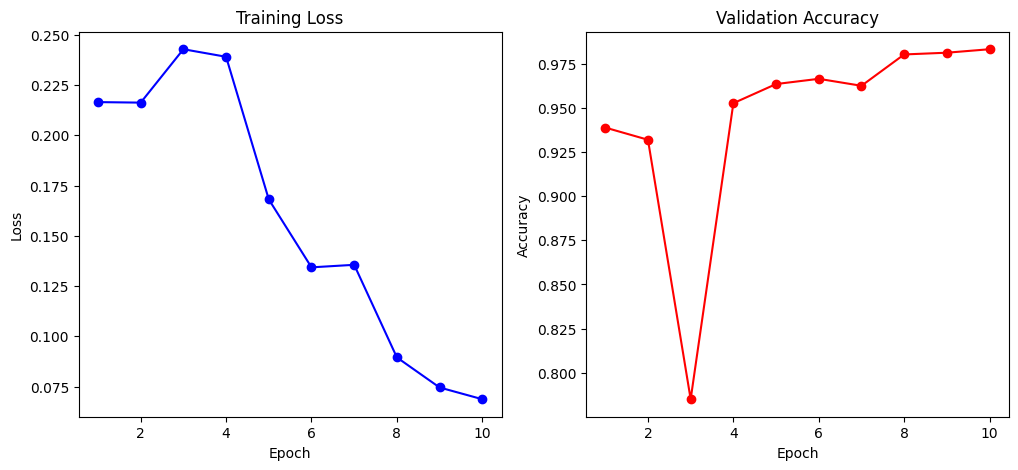

In [133]:
# ✅
def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12,5))
    # trai
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], 'b-o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    # val
    plt.subplot(1,2,2)
    plt.plot(epochs, history["val_accuracy"], 'r-o')
    plt.title("Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")

    plt.show()
plot_history(history)

In [134]:
# ✅
best_model.eval()
best_model = best_model.to(device)
correct = 0
total = 0

pred = []
labels_list = []
with torch.no_grad():
    for images, labels in Test_B:
        images, labels = images.to(device), labels.to(device)
        outputs = best_model(images)
        predicted = torch.max(outputs, 1)[1]
        pred.append(predicted)
        labels_list.append(labels)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()


y_pred = torch.cat(pred).cpu()
y_labels = torch.cat(labels_list).cpu()
test_acc = correct / total
print(f"Test Accuracy: {test_acc:.4f}")



Test Accuracy: 0.9805


In [135]:
from sklearn.metrics import confusion_matrix, classification_report

print("\nClassification report:\n")
print(classification_report(y_labels, y_pred, target_names=class_names, digits=4))


Classification report:

              precision    recall  f1-score   support

      cloudy     0.9551    0.9933    0.9739       150
       water     0.9801    0.9867    0.9834       150
  green_area     1.0000    0.9733    0.9865       150
      desert     0.9910    0.9649    0.9778       114

    accuracy                         0.9805       564
   macro avg     0.9816    0.9796    0.9804       564
weighted avg     0.9810    0.9805    0.9805       564



In [136]:
# ✅
torch.save(best_model.state_dict(), "model1.pth")

In [137]:
# ✅
def predict_random_image(model, img_paths, class_names, device):
    img_path = random.choice(img_paths)
    img = Image.open(img_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    input_tensor = transform(img).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        logits = model(input_tensor)
        probs = torch.softmax(logits, dim=1)
        predicted_idx = probs.argmax(dim=1).item()
        confidence = probs[0, predicted_idx].item()

    predicted_label = class_names[predicted_idx]

    #  PLOTTING HERE
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.axis("off")
    plt.show()

    print(f"Image path: {img_path}")


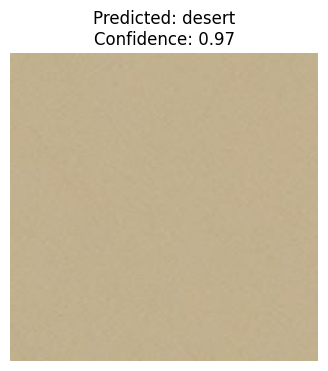

Image path: data/desert/desert(737).jpg


In [144]:
# ✅
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = MiniVGG(num_classes=len(class_names)).to(device)
model.load_state_dict(torch.load("model1.pth", map_location=device))
model.eval()

predict_random_image(model, Test_paths, class_names, device)
